# 数据处理，特征选择，建模过程

In [2]:
import os, re, json, gc, itertools
import time
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import joblib
import xgboost as xgb
import lightgbm as lgb


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score


In [3]:
# load data
train = pd.read_csv(r'D:\data\second_round_training_data.csv')
test = pd.read_csv(r'D:\data\second_round_testing_data.csv')
# 缺失值检查

print(train.isnull().sum())
print(test.isnull().sum())

Parameter1       0
Parameter2       0
Parameter3       0
Parameter4       0
Parameter5       0
Parameter6       0
Parameter7       0
Parameter8       0
Parameter9       0
Parameter10      0
Attribute1       0
Attribute2       0
Attribute3       0
Attribute4       0
Attribute5       0
Attribute6       0
Attribute7       0
Attribute8       0
Attribute9       0
Attribute10      0
Quality_label    0
dtype: int64
Group             0
Parameter1        0
Parameter10       0
Parameter2        0
Parameter3        0
Parameter4        0
Parameter5        0
Parameter6        0
Parameter7        0
Parameter8        0
Parameter9     3000
dtype: int64


In [3]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

<AxesSubplot:ylabel='Density'>

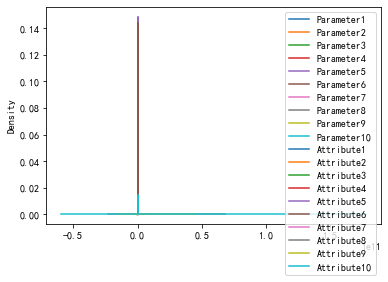

In [7]:
train.plot(kind='kde') #KDE图，KDE图也被称作密度图(Kernel Density Estimate,核密度估计)

<AxesSubplot:ylabel='Density'>

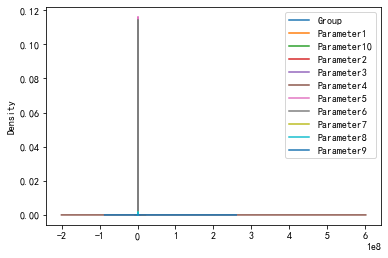

In [8]:
test.plot(kind='kde') #KDE图，KDE图也被称作密度图(Kernel Density Estimate,核密度估计)

In [4]:
# train 分离 target
target = train.pop('Quality_label')


In [5]:
# target 编码
target = (target.astype("category")
          .cat.set_categories(["Fail", "Pass", "Good", "Excellent"])
          .cat.codes)
target = target.rename('target')

In [4]:
# train 分离 parameter 和 attribute
col_attr=[f'Attribute{x}' for x in range(1,11)]
attr = train[col_attr]
train = train.drop(columns=col_attr)
train

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Quality_label
0,0.167898,104.443982,2.772825,0.146548,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,Pass
1,252.483066,0.343232,0.066873,0.002495,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,Fail
2,4.124654,0.170534,0.383800,0.000004,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,Fail
3,294.656750,6.153711,0.014716,4284.326273,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,Fail
4,0.026284,0.166810,7.587398,0.002202,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,Fail
...,...,...,...,...,...,...,...,...,...,...,...
12929,0.047691,4100.626150,206.419171,963.227568,0.027434,0.044685,0.600827,0.118077,887.611257,100.165262,Fail
12930,25.364398,8.175837,0.022862,0.145178,3.856009,3.965023,0.600827,17.850021,6.783967,2.705518,Pass
12931,0.001252,0.029016,10.955593,1.436280,3.856009,3.262468,0.600827,17.850021,6.783967,2.705518,Pass
12932,0.027662,0.118413,554.722425,5.398536,3.454681,7.117767,0.600827,17.850021,6.783967,2.705518,Pass


In [25]:
# test 分离 group
group = test.pop('Group')
group = group.rename('group')

In [ ]:
## 合并标签和特征信息
import  seaborn as sns
train = train.copy() ##进行浅拷贝，防止对于原始数据的修改
train['target'] = target
## 特征与标签组合的散点可视化
sns.pairplot(data=train,diag_kind='hist', hue= 'target')
plt.show()


In [26]:
# test 调整参数顺序，与 train 保持一致
col_test = [f"Parameter{x}" for x in range(1, 11)]
test = test[col_test]

In [9]:
# 简化列名
colnames = [f'p{i}' for i in range(1,11)]
train.columns = colnames
test.columns = colnames
colnames = [f'a{i}' for i in range(1,11)]
attr.columns = colnames

In [10]:
# rounding
round_fmt = {1:11,2:11,3:11,4:11,
             5:8,6:8,7:8,8:8,9:8,10:8}
for i,r in round_fmt.items():
    train[f'p{i}']=train[f'p{i}'].round(r)
    test[f'p{i}']=test[f'p{i}'].round(r)

In [11]:
# transform log2
# 对数转换和归一化后存在负数，影响加减乘除的结果
# 需要测试对数转换前的效果
train = train.apply(np.log2)
attr = attr.apply(np.log2)
test = test.apply(np.log2)

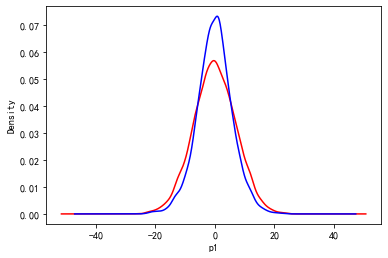

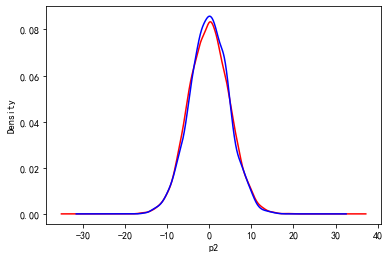

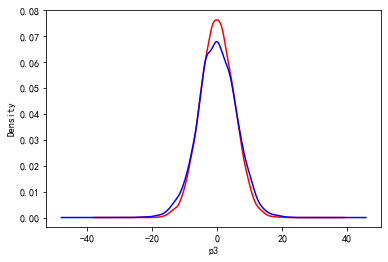

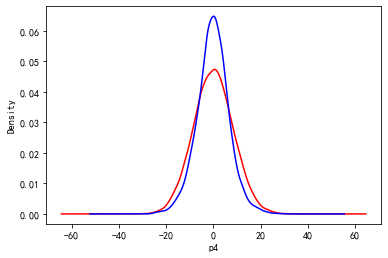

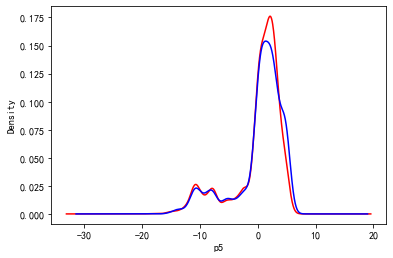

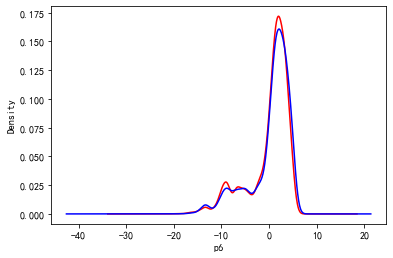

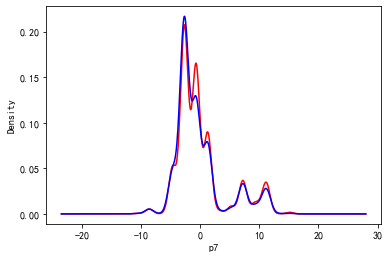

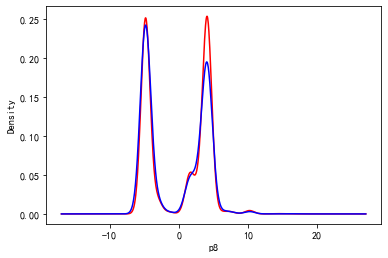

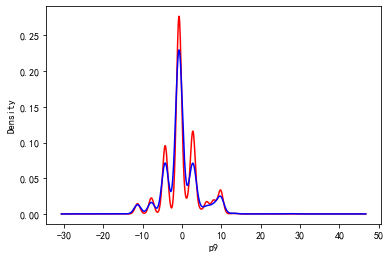

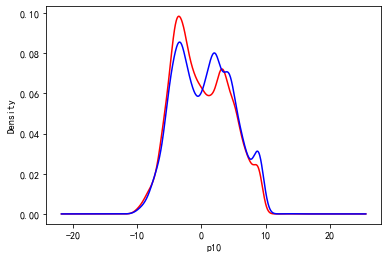

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
for i in train.columns:
    train[i].plot.density(c='r')
    test[i].plot.density(c='b')
    plt.xlabel(i)
    plt.show()

In [12]:
train

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,-2.574342,6.706586,1.471356,-2.770559,-11.213036,-10.674110,11.158940,-4.819815,-0.753698,0.014905
1,7.980043,-1.542744,-3.902437,-8.646580,-10.103131,-8.704548,11.158940,-4.819815,-0.753698,0.014905
2,2.044273,-2.551867,-1.381575,-17.836103,-10.103131,-8.985913,11.158940,-4.819815,-0.753698,0.014905
3,8.202892,2.621457,-6.086486,12.064853,-10.103131,-8.704548,11.158940,-4.819815,-0.753698,0.014905
4,-5.249664,-2.583727,2.923605,-8.826878,-10.103131,-8.704548,11.158940,-4.819815,-0.753698,0.014905
...,...,...,...,...,...,...,...,...,...,...
12929,-4.390145,12.001629,7.689433,9.911733,-5.187904,-4.484070,-0.734979,-3.082201,9.793784,6.646238
12930,4.664733,3.031366,-5.450894,-2.784105,1.947108,1.987329,-0.734979,4.157854,2.762129,1.435905
12931,-9.641612,-5.106998,3.453596,0.522337,1.947108,1.705964,-0.734979,4.157854,2.762129,1.435905
12932,-5.175952,-3.078100,9.115622,2.432568,1.788553,2.831425,-0.734979,4.157854,2.762129,1.435905


In [11]:
# 保留 P5-P10
train = train.drop(columns=[f'p{i}' for i in range(1,5)])
test = test.drop(columns=[f'p{i}' for i in range(1,5)])

In [12]:
print(train.shape,test.shape)
test['p9_isnull']=test['p9'].isna()
test_na=test[test['p9_isnull']==False]
lbl=LabelEncoder()#标签编码
lbl.fit(list(test_na['p9'])+list(train['p9']))
test_na['p9']=lbl.transform(test_na['p9'])
train['p9']=lbl.transform(train['p9'])
test.loc[test['p9_isnull']==False,'p9']=test_na
del test_na

(12934, 6) (6000, 6)


<ipython-input-12-cd79e75ffe39>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_na['p9']=lbl.transform(test_na['p9'])


In [13]:
test['p9_isnull']=test['p9'].isna()
test_not_na=test[test['p9_isnull']==False]
lbl=LabelEncoder()
lbl.fit(list(test_not_na['p9'])+list(train['p9']))
test_not_na['p9']=lbl.transform(test_not_na['p9'])
train['p9']=lbl.transform(train['p9'])
test.loc[test['p9_isnull']==False,'p9']=test_not_na
del test_not_na

<ipython-input-13-1d8b4b3eea95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_not_na['p9']=lbl.transform(test_not_na['p9'])


In [14]:
parameter='p9'

In [15]:
p9=train['p9']
train=train.drop(columns='p9')
df=train.join(p9)

In [16]:
test_not_na=test[test['p9_isnull']==True]

In [17]:
test_not_na=test_not_na.drop(columns=['p9','p9_isnull'])

In [18]:
best_hp={'boosting_type': 'gbdt',
 'num_leaves': 111,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 639,
 'subsample_for_bin': 200000,
 'objective': 'multiclass',
 'min_split_gain': 0,
 'min_child_weight': 0.001,
 'min_child_samples': 5,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1,
 'reg_alpha': 0.20174465129035402,
 'reg_lambda': 0.18200878389736302,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 'num_class': 17}

In [19]:
m = lgb.LGBMClassifier().set_params(**best_hp)
m.fit(train,p9)

LGBMClassifier(colsample_bytree=1, min_child_samples=5, min_split_gain=0,
               n_estimators=639, num_class=17, num_leaves=111,
               objective='multiclass', reg_alpha=0.20174465129035402,
               reg_lambda=0.18200878389736302)

In [20]:
res=m.predict(test_not_na)

In [21]:
test.loc[test['p9_isnull']==True,'p9']=res

In [22]:
test['p9']=test['p9'].astype(int)
test=test.drop(columns='p9_isnull')

In [23]:
p10=train['p10']
train=train.drop(columns='p10')
train=train.join(p9)
train=train.join(p10)

In [24]:
train['p9'].min()

0

In [25]:
attribute='a4'
df = train.join(attr[attribute])

In [26]:
best_hp={'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 571,
 'verbosity': 1,
 'objective': 'reg:squarederror',
 'booster': 'dart',
 'n_jobs': -1,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'reg_alpha': 6.345561548486771,
 'reg_lambda': 2.808394786832976,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'importance_type': 'gain',
 'num_round': 223}

In [27]:
x_trn,x_val,y_trn,y_val = train_test_split(train,attr.a4,test_size=1000)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn,y_trn)

[19:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=571, n_jobs=-1,
             num_parallel_tree=1, num_round=223, predictor='auto',
             random_state=0, reg_alpha=6.345561548486771,
             reg_lambda=2.808394786832976, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [28]:
# 保存模型
joblib.dump(m,f'D:\\机器学习\\model\\tp3_{attribute}.m')

['D:\\机器学习\\model\\tp3_a4.m']

In [29]:
attribute='a5'

In [30]:
df = train.join(attr[attribute])

In [31]:
best_hp={'max_depth': 4,
 'learning_rate': 0.1,
 'n_estimators': 749,
 'verbosity': 1,
 'objective': 'reg:squarederror',
 'booster': 'dart',
 'n_jobs': -1,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'reg_alpha': 7.819025434063891,
 'reg_lambda': 0.005996946163704,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'importance_type': 'gain',
 'num_round': 934}

In [32]:
x_trn,x_val,y_trn,y_val = train_test_split(train,attr.a5,test_size=1000)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn,y_trn)

[19:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=749, n_jobs=-1,
             num_parallel_tree=1, num_round=934, predictor='auto',
             random_state=0, reg_alpha=7.819025434063891,
             reg_lambda=0.005996946163704, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [33]:
# 保存模型
joblib.dump(m,f'D:\\机器学习\\model\\tp3_{attribute}.m')

['D:\\机器学习\\model\\tp3_a5.m']

In [34]:
attribute='a6'

In [35]:
df = train.join(attr[attribute])

In [36]:
best_hp={'max_depth': 4,
 'learning_rate': 0.1,
 'n_estimators': 731,
 'verbosity': 1,
 'objective': 'reg:squarederror',
 'booster': 'dart',
 'n_jobs': -1,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'reg_alpha': 9.299861941127418,
 'reg_lambda': 8.762447153395918,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'importance_type': 'gain',
 'num_round': 917}

In [37]:
x_trn,x_val,y_trn,y_val = train_test_split(train,attr.a6,test_size=1000)
m = xgb.XGBRegressor().set_params(**best_hp)
m.fit(x_trn,y_trn)

[19:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=731, n_jobs=-1,
             num_parallel_tree=1, num_round=917, predictor='auto',
             random_state=0, reg_alpha=9.299861941127418,
             reg_lambda=8.762447153395918, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [38]:
# 保存模型
joblib.dump(m,f'D:\\机器学习\\model\\tp3_{attribute}.m')

['D:\\机器学习\\model\\tp3_a6.m']

In [39]:
# stacking 建立 attr 特征
cv = KFold(6,shuffle=True,random_state=1)
attrs = [f'a{i}' for i in range(4, 7)]
trn_res = None
tst_res = None
for attribute in attrs:
    print(attribute)
    m = joblib.load(f'D:\\机器学习\\model\\tp3_{attribute}.m')
    trn_attr = None
    tst_attr = None
    for index, (trn_idx, val_idx) in enumerate(cv.split(train, attr[attribute])):
        x_trn, x_val = train.iloc[trn_idx], train.iloc[val_idx]
        y_trn, y_val = attr[attribute].iloc[trn_idx], attr[attribute].iloc[val_idx]
        m.fit(x_trn, y_trn)
        if trn_attr is None:
            trn_attr = np.c_[val_idx, m.predict(x_val)]
            tst_attr = m.predict(test)/cv.n_splits
        else:
            trn_attr = np.r_[trn_attr, np.c_[val_idx, m.predict(x_val)]]
            tst_attr += m.predict(test)/cv.n_splits
    trn_attr = pd.DataFrame(trn_attr).set_index(0)
    trn_attr.index = trn_attr.index.astype('int')
    trn_attr.columns = [attribute]
    if trn_res is None:
        trn_res = trn_attr
        tst_res = tst_attr
    else:
        trn_res = trn_res.join(trn_attr)
        tst_res = np.c_[tst_res,tst_attr]

a4
[19:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:19:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This coul

In [40]:
train = train.join(trn_res)
tst_res = pd.DataFrame(tst_res)
tst_res.columns = [f'a{i}' for i in range(4,7)]
test = test.join(tst_res)

In [41]:
# save data
save_path = 'D:\\data\\tp6.h5'
train.to_hdf(save_path,'train')
target.to_hdf(save_path,'target')
test.to_hdf(save_path,'test')
attr.to_hdf(save_path,'attr')
group.to_hdf(save_path,'group')

In [42]:
# load data
load_path = 'D:\\data\\tp6.h5'
train = pd.read_hdf(load_path,'train')
target = pd.read_hdf(load_path,'target')
test = pd.read_hdf(load_path,'test')
attr = pd.read_hdf(load_path,'attr')
group = pd.read_hdf(load_path,'group')

In [43]:
def create_uid(df,cols,uid_name):
    df[uid_name]=df[cols[0]].astype(str)
    if len(cols)>1:
        for c in cols[1:]:
            df[uid_name]=df[uid_name]+df[c].astype(str)
    return df

def uid_aggregation(train,test,main_cols,uid,agg_method):
    for main_col in main_cols:
        new_col_name=uid+'_'+main_col+'_'+agg_method
        train[new_col_name]=train.groupby([uid])[main_col].transform(agg_method)
        test[new_col_name]=test.groupby([uid])[main_col].transform(agg_method)

def frequency_encoding(train,test,cols):
    for c in cols:
        new_col_name=c+'_freq'
        train[new_col_name] = train[c].map(train[c].value_counts())
        test[new_col_name] = test[c].map(test[c].value_counts())

def nunique_encoding(train,test,main_cols,col):
    for main_col in main_cols:
        new_col_name=main_col+'_'+col+'_nunique'
        train[new_col_name]= train[col].map(train.groupby(col)[main_col].nunique())
        test[new_col_name]= test[col].map(test.groupby(col)[main_col].nunique())

In [44]:
for c in range(4,7):
    col='a'+str(c)
    train[col]=train[col].round(3)
    test[col]=test[col].round(3)

# creat uids
for key,value in {'uid1':['p5','p6'],'uid2':['p7','p9','p10'],'uid3':['p5','p6','p7','p8','p9'],'uid4':['p10', 'p9', 'p8', 'p7']}.items():
    train=create_uid(train,cols=value,uid_name=key)
    test=create_uid(test,cols=value,uid_name=key)
    
# apply uid_aggregation
uid_aggregation(train,test,main_cols=['a4','a5'],uid='p7',agg_method='mean')
uid_aggregation(train,test,main_cols=['a4','a5','a6'],uid='uid4',agg_method='mean')
uid_aggregation(train,test,main_cols=['a4'],uid='uid4',agg_method='std')
uid_aggregation(train,test,main_cols=['p5','p6'],uid='uid4',agg_method='sum')

# apply frequency_encoding
frequency_encoding(train,test,cols=['p7','p8','p10'])

# apply unique_encoding
nunique_encoding(train,test,main_cols=['p8','p9','p10'],col='p7')
nunique_encoding(train,test,main_cols=['p9'],col='p8')
nunique_encoding(train,test,main_cols=['uid2','uid3'],col='uid1')
nunique_encoding(train,test,main_cols=['uid3'],col='uid2')

# a4+a5+a6
train['a4_plus_a5_plus_a6']=train['a4']+train['a5']+train['a6']
test['a4_plus_a5_plus_a6']=test['a4']+test['a5']+test['a6']

# majic_fe
train['majic_fe']=train['uid4_p5_sum']*train['uid4_p6_sum']
test['majic_fe']=test['uid4_p5_sum']*test['uid4_p6_sum']

# drop_cols
drop_cols=['uid1','uid2','uid3','uid4','uid4_p5_sum','uid4_p6_sum']
train =train.drop(columns=drop_cols)
test =test.drop(columns=drop_cols)

In [45]:
best_hp={'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 203,
 'verbosity': 1,
 'objective': 'multi:softmax',
 'booster': 'dart',
 'n_jobs': -1,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'reg_alpha': 6.736871781492226,
 'reg_lambda': 0.073512560432491,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'num_class': 4,
 'num_round': 295}

In [47]:
from sklearn.metrics import log_loss, accuracy_score

oof = np.zeros((train.shape[0], 4))
prediction = np.zeros((test.shape[0], 4))
seeds = [123456, 87654, 676767]
num_model_seed = 3
for model_seed in range(num_model_seed):
    print("开始训练第%d个模型：" % (model_seed + 1))
    oof_cat = np.zeros((train.shape[0], 4))
    prediction_cat = np.zeros((test.shape[0], 4))
    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(train, target)):
        print("正在训练第%d折" % (index + 1))
        train_x, test_x, train_y, test_y = train.iloc[train_index], train.iloc[test_index], target.iloc[train_index], \
                                           target.iloc[test_index]
        gc.collect()
        m = xgb.XGBClassifier().set_params(**best_hp).set_params(n_jobs=-1,learning_rate=0.05)
        m.fit(train_x, train_y) # xgb需要接受的是字典
        oof_cat[test_index] += m.predict_proba(test_x)
        prediction_cat += m.predict_proba(test) / skf.n_splits
        gc.collect()
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
    print('logloss', log_loss(pd.get_dummies(target).values, oof_cat))
    print('ac', accuracy_score(target, np.argmax(oof_cat, axis=1)))
print("*" * 30)
print('mean_logloss', log_loss(pd.get_dummies(target).values, oof))
print('mean_ac', accuracy_score(target, np.argmax(oof, axis=1)))

group_size=50
mname='CCF_model_xgb'
res_prob = pd.DataFrame(np.c_[group,prediction])
res_prob.columns=['Group', 'Fail ratio', 'Pass ratio', 'Good ratio', 'Excellent ratio']
res_prob = res_prob[['Group', 'Excellent ratio','Good ratio', 'Pass ratio','Fail ratio']]
res_prob =(res_prob.groupby('Group').sum()/group_size).reset_index()
res_prob.to_csv(f'D:\\机器学习\\submission\\{mname}_prob.csv',index=False,encoding='utf-8')

开始训练第1个模型：
正在训练第1折
[19:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


正在训练第2折
[19:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
正在训练第3折
[19:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used 

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


正在训练第2折
[20:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
正在训练第3折
[20:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used 

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


正在训练第2折
[20:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
正在训练第3折
[20:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used 

In [48]:
len(train.columns)

27

In [49]:
train.columns

Index(['p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'a4', 'a5', 'a6', 'p7_a4_mean',
       'p7_a5_mean', 'uid4_a4_mean', 'uid4_a5_mean', 'uid4_a6_mean',
       'uid4_a4_std', 'p7_freq', 'p8_freq', 'p10_freq', 'p8_p7_nunique',
       'p9_p7_nunique', 'p10_p7_nunique', 'p9_p8_nunique', 'uid2_uid1_nunique',
       'uid3_uid1_nunique', 'uid3_uid2_nunique', 'a4_plus_a5_plus_a6',
       'majic_fe'],
      dtype='object')